In [1]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
from data_loading import *
from data_preprocessing import *
from model import *

In [10]:
import time
import os

In [11]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
TF_ENABLE_ONEDNN_OPTS=0

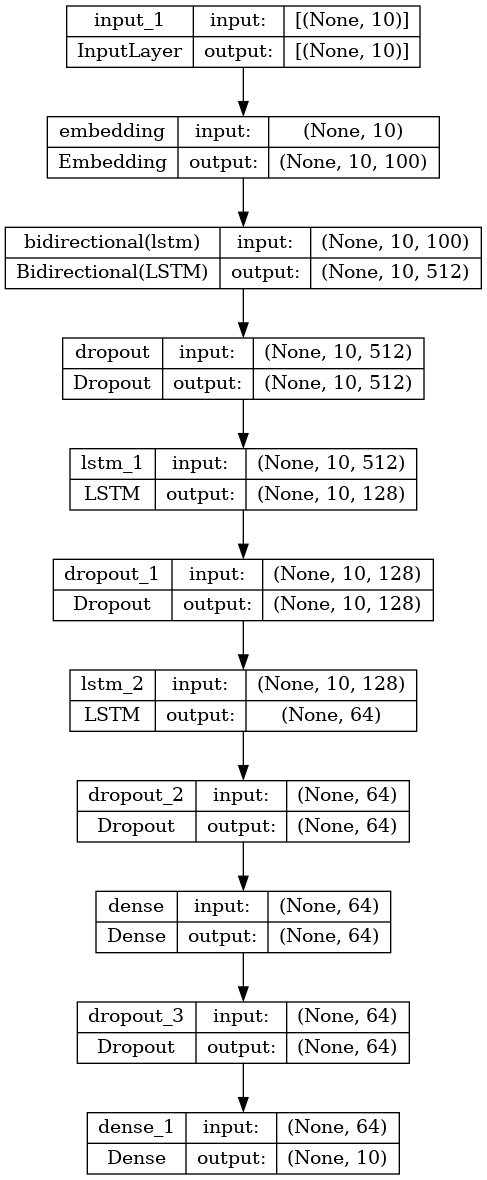

In [6]:
from keras.utils.vis_utils import plot_model
# plot the model diavgram
plot_model(model, to_file='LSTM_2_model_diagram.png', show_shapes=True, show_layer_names=True)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding (Embedding)       (None, 10, 100)           28197700  
                                                                 
 bidirectional (Bidirectiona  (None, 10, 512)          731136    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           328192    
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                             

In [8]:
# from tensorflow.keras.models import load_model

# # If previous model exists, load it
# if os.path.exists('save/LSTM_model.h5'):
#     model_lstm = load_model('save/LSTM_model.h5')


In [14]:
%%time

# The result may differ slightly with the final report

# Save model after every 10 epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=1, verbose=1, factor=0.1, min_delta=0.001, min_lr=0.00001)
    
with tf.device('/GPU:0'):
   
    # Train the model for 10 epochs
    
    history_LSTM = model.fit(x=train_data, y=train_classes,
                        batch_size=1024, shuffle=True,
                        validation_data=(val_data, val_classes),
                        callbacks=[reduce_lr, early_stopping],
                        epochs = 40)

# Save model
model.save(f'save/LSTM_model_epoch_swish.h5')
    
# Append the loss values to the lists
train_loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']
train_acc = history_LSTM.history['accuracy']
val_acc = history_LSTM.history['val_accuracy']

# Save loss to txt files
if not os.path.exists('Epoch_history'):
    os.makedirs('Epoch_history')
np.savetxt('Epoch_history/train_loss_lstm_swish.txt', train_loss, delimiter=',')
np.savetxt('Epoch_history/val_loss_lstm_swish.txt', val_loss, delimiter=',')
np.savetxt('Epoch_history/train_acc_lstm_swish.txt', train_acc, delimiter=',')
np.savetxt('Epoch_history/val_acc_lstm_swish.txt', val_acc, delimiter=',')

Epoch 1/40
941/941 [==============================] - 237s 252ms/step - loss: 1.0393 - accuracy: 0.6737 - val_loss: 1.0103 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 2/40
941/941 [==============================] - 268s 285ms/step - loss: 0.9734 - accuracy: 0.6941 - val_loss: 1.0073 - val_accuracy: 0.6810 - lr: 0.0010
Epoch 3/40
941/941 [==============================] - ETA: 0s - loss: 0.9189 - accuracy: 0.7108
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
941/941 [==============================] - 259s 275ms/step - loss: 0.9189 - accuracy: 0.7108 - val_loss: 1.0057 - val_accuracy: 0.6813 - lr: 0.0010
Epoch 4/40
941/941 [==============================] - 255s 271ms/step - loss: 0.8553 - accuracy: 0.7312 - val_loss: 1.0179 - val_accuracy: 0.6833 - lr: 1.0000e-04
Epoch 5/40
941/941 [==============================] - ETA: 0s - loss: 0.8472 - accuracy: 0.7331
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
941/941 [================

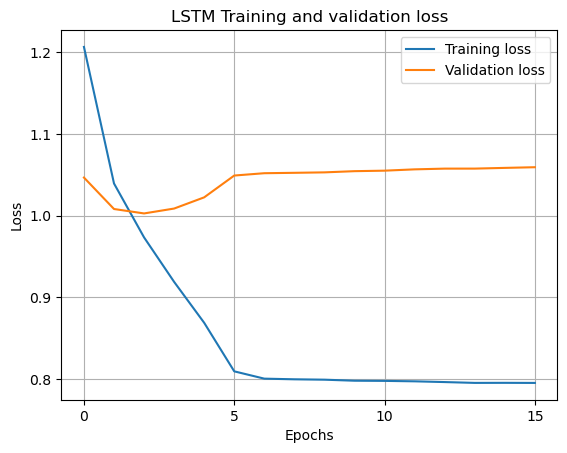

In [15]:
import matplotlib.pyplot as plt

train_loss = np.loadtxt('Epoch_history/train_loss_lstm_swish.txt', delimiter=',')
val_loss = np.loadtxt('Epoch_history/val_loss_lstm_swish.txt', delimiter=',')

epochs = range(0, len(train_loss),5)

plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('LSTM Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper right')

plt.legend()
plt.show()


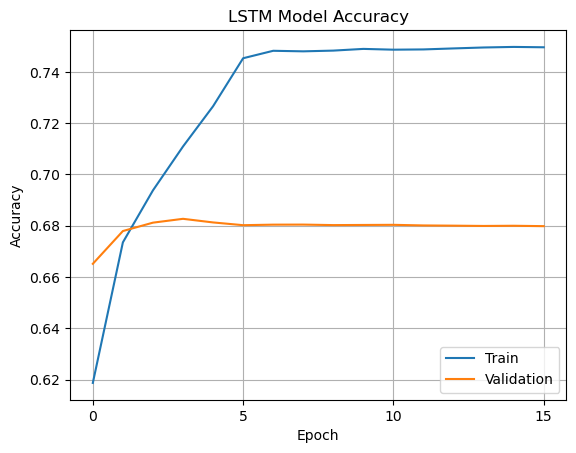

In [19]:
# plt.plot(history_LSTM.history['accuracy'])
# plt.plot(history_LSTM.history['val_accuracy'])
train_acc = np.loadtxt('Epoch_history/train_acc_lstm_swish.txt', delimiter=',')
val_acc = np.loadtxt('Epoch_history/val_acc_lstm_swish.txt', delimiter=',')
plt.plot(train_acc)
plt.plot(val_acc,)
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid()
plt.xticks(epochs)

plt.show()

In [18]:
from tensorflow.keras.models import load_model

# If previous model exists, load it
if os.path.exists('save/LSTM_model_epoch_swish.h5'):
    model_lstm = load_model('save/LSTM_model_epoch_swish.h5')

## Test

In [31]:
# with open('data_sequences_test.pkl','rb') as file:
#   test_data = pickle.load(file)

# with open('data_label_test.pkl','rb') as file:
#   test_labels = pickle.load(file)
test_data = test_data
test_labels = test_classes

6448/6448 [==============================] - 109s 17ms/step


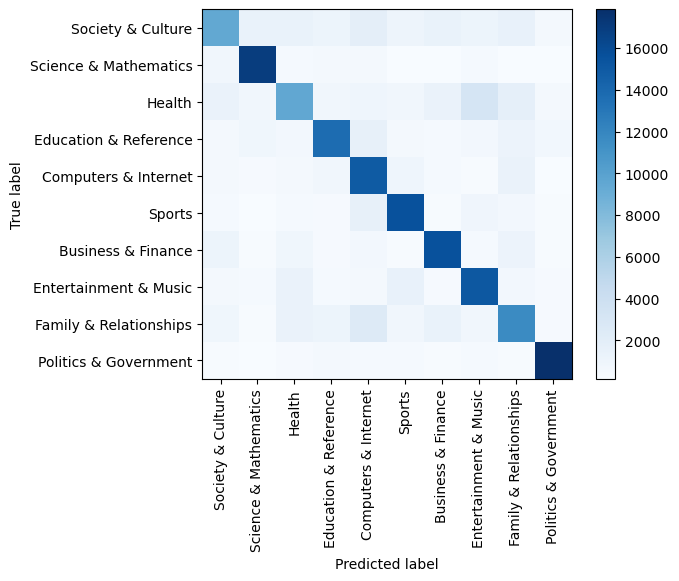

Accuracy: 0.680897471317852


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the class labels
class_names = ['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference', 'Computers & Internet', 
               'Sports', 'Business & Finance', 'Entertainment & Music', 'Family & Relationships', 'Politics & Government']


# Make predictions on the test set
predictions = model.predict(test_data)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

# Visualize the confusion matrix as a heatmap
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(10), class_names, rotation=90)
plt.yticks(range(10), class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Calculate and print the accuracy
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(test_labels, axis=1)) / len(np.argmax(test_labels, axis=1))
print('Accuracy:', accuracy)


In [21]:
from sklearn.metrics import classification_report
target_names = class_names
y_true = np.argmax(test_labels, axis=1) 
y_pred = np.argmax(predictions, axis=1) 
print(classification_report(y_true=y_true,y_pred= y_pred, target_names=target_names))

                        precision    recall  f1-score   support

     Society & Culture       0.60      0.45      0.52     20687
 Science & Mathematics       0.79      0.83      0.81     20123
                Health       0.57      0.46      0.51     20645
 Education & Reference       0.69      0.66      0.68     20636
  Computers & Internet       0.59      0.74      0.66     20086
                Sports       0.71      0.75      0.73     20550
    Business & Finance       0.72      0.75      0.73     20800
 Entertainment & Music       0.65      0.71      0.68     20998
Family & Relationships       0.58      0.56      0.57     20805
 Politics & Government       0.85      0.85      0.85     20983

              accuracy                           0.68    206313
             macro avg       0.67      0.68      0.67    206313
          weighted avg       0.67      0.68      0.67    206313



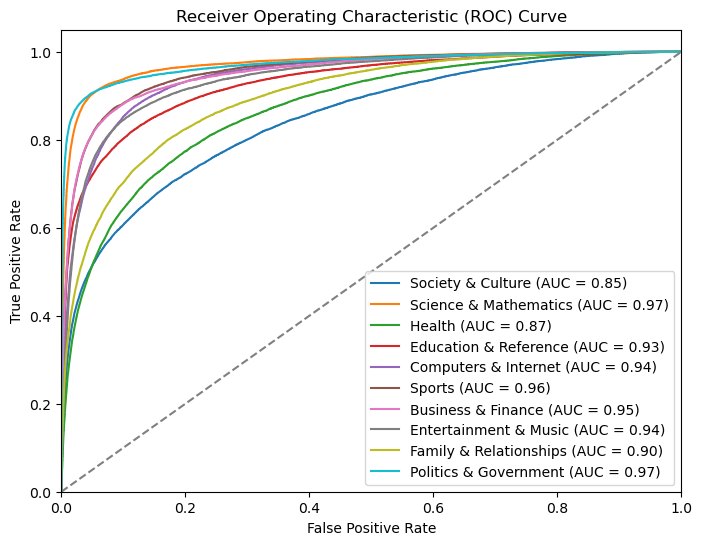

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl

mpl.rcParams['font.size'] = 10




# Make predictions on the test set
predictions =predictions

# Convert the labels to categorical format
test_labels_cat = test_labels

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_cat[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [33]:
from sklearn.metrics import roc_auc_score
y_pred = predictions
score = roc_auc_score(test_labels, y_pred)
print("\n ROC-AUC score: %.6f \n" % (score))


 ROC-AUC score: 0.931775 

